In [1]:
import numpy as np
import matplotlib.pyplot as plt

from alpub_autoencoder.autoencoder_utils import read_alpub_data
from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
ALPUB_PATH = '../../Datasets/alpub_v2/images'

In [3]:
X,Y = read_alpub_data(path=ALPUB_PATH)

Processing Alpha
Processing Beta
Processing Chi
Processing Delta
Processing Epsilon
Processing Eta
Processing Gamma
Processing Iota
Processing Kappa
Processing Lambda
Processing LunateSigma
Processing Mu
Processing Nu
Processing Omega
Processing Omicron
Processing Phi
Processing Pi
Processing Psi
Processing Rho
Processing Tau
Processing Theta
Processing Upsilon
Processing Xi
Processing Zeta


In [4]:
Y.shape

(205797, 24)

In [5]:
X.shape

(205797, 70, 70, 3)

In [6]:
# Convert the RGB images to grayscale
X_gray = []
for img in X:
    image_gray = Image.fromarray(img).convert("L")
    X_gray.append(np.array(image_gray))

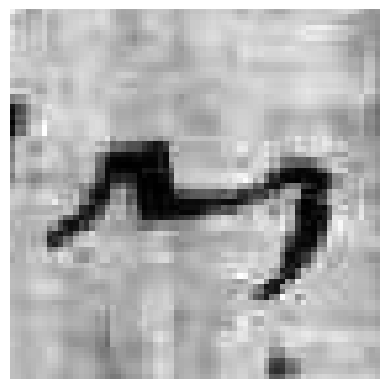

In [7]:
# Display the grayscale image
plt.imshow(X_gray[100000], cmap="gray")
plt.axis("off")
plt.show()

In [8]:
X_in = np.array(X_gray).reshape(len(X_gray), -1)

In [9]:
X_in.shape

(205797, 4900)

In [10]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_test, Y_train, Y_test = train_test_split(X_in, Y, test_size=0.1, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, stratify=Y_train)

In [11]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Test images shape:",X_test.shape)
print("Test labels shape:",Y_test.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (166695, 4900)
Train labels shape: (166695, 24)
Test images shape: (20580, 4900)
Test labels shape: (20580, 24)
Validation images shape: (18522, 4900)
Validation labels shape: (18522, 24)


In [12]:
#Autoencoder Implementation

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [13]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [15]:
train_dataset = CharacterDataset(X_train, Y_train)
test_dataset = CharacterDataset(X_test, Y_test)
val_dataset = CharacterDataset(X_val, Y_val)

In [18]:
# Simple Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Training model with 2 latent dimensions...
Epoch [1/10], Train Loss: 2768.1054, Test Loss: 1123.9600
Epoch [2/10], Train Loss: 1145.7978, Test Loss: 1109.1332
Epoch [3/10], Train Loss: 1077.6333, Test Loss: 1011.5105
Epoch [4/10], Train Loss: 1027.4188, Test Loss: 1011.8740
Epoch [5/10], Train Loss: 1026.0015, Test Loss: 1006.8572
Epoch [6/10], Train Loss: 1022.5437, Test Loss: 1013.2635
Epoch [7/10], Train Loss: 1021.7982, Test Loss: 1006.7565
Epoch [8/10], Train Loss: 1022.1504, Test Loss: 1006.9100
Epoch [9/10], Train Loss: 1020.3269, Test Loss: 1006.5051
Epoch [10/10], Train Loss: 1020.1900, Test Loss: 1006.6276


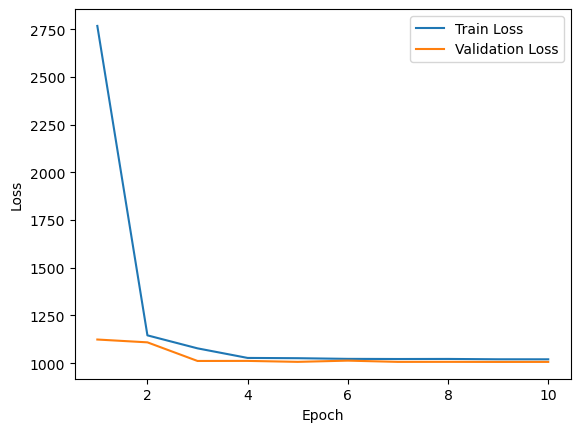

Training model with 5 latent dimensions...
Epoch [1/10], Train Loss: 2085.9305, Test Loss: 1164.2549
Epoch [2/10], Train Loss: 1086.8631, Test Loss: 955.6786
Epoch [3/10], Train Loss: 869.9853, Test Loss: 845.3244
Epoch [4/10], Train Loss: 818.0056, Test Loss: 818.1720
Epoch [5/10], Train Loss: 813.1950, Test Loss: 799.5861
Epoch [6/10], Train Loss: 813.4916, Test Loss: 845.8239
Epoch [7/10], Train Loss: 810.8281, Test Loss: 865.6139
Epoch [8/10], Train Loss: 810.8220, Test Loss: 800.7348
Epoch [9/10], Train Loss: 809.7274, Test Loss: 798.2987
Epoch [10/10], Train Loss: 809.4139, Test Loss: 798.5855


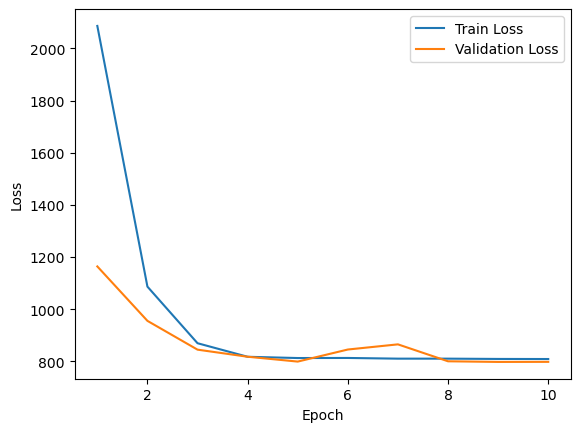

Training model with 10 latent dimensions...
Epoch [1/10], Train Loss: 1813.5072, Test Loss: 1094.6576
Epoch [2/10], Train Loss: 890.7383, Test Loss: 750.5962
Epoch [3/10], Train Loss: 684.4961, Test Loss: 634.6118
Epoch [4/10], Train Loss: 645.5778, Test Loss: 684.4368
Epoch [5/10], Train Loss: 640.4111, Test Loss: 653.4613
Epoch [6/10], Train Loss: 639.3816, Test Loss: 646.7660
Epoch [7/10], Train Loss: 637.2625, Test Loss: 657.4810
Epoch [8/10], Train Loss: 637.7211, Test Loss: 626.0814
Epoch [9/10], Train Loss: 635.4965, Test Loss: 651.7419
Epoch [10/10], Train Loss: 635.1643, Test Loss: 627.7570


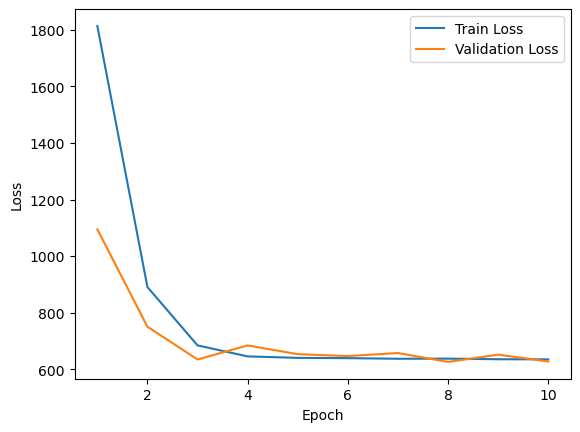

Training model with 25 latent dimensions...
Epoch [1/10], Train Loss: 1283.8934, Test Loss: 717.6391
Epoch [2/10], Train Loss: 582.6881, Test Loss: 448.1210
Epoch [3/10], Train Loss: 432.6344, Test Loss: 392.7813
Epoch [4/10], Train Loss: 408.5497, Test Loss: 412.9418
Epoch [5/10], Train Loss: 404.1734, Test Loss: 394.2782
Epoch [6/10], Train Loss: 402.4405, Test Loss: 396.2527
Epoch [7/10], Train Loss: 401.7463, Test Loss: 393.3359
Epoch [8/10], Train Loss: 401.1376, Test Loss: 392.8686
Epoch [9/10], Train Loss: 401.3936, Test Loss: 393.5650
Epoch [10/10], Train Loss: 400.5972, Test Loss: 410.2405


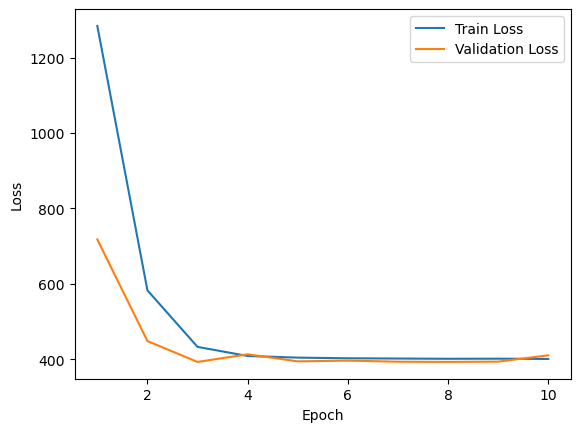

Training model with 50 latent dimensions...
Epoch [1/10], Train Loss: 1022.3208, Test Loss: 504.8558
Epoch [2/10], Train Loss: 418.6834, Test Loss: 339.4997
Epoch [3/10], Train Loss: 302.2113, Test Loss: 315.6216
Epoch [4/10], Train Loss: 272.1963, Test Loss: 288.9985
Epoch [5/10], Train Loss: 263.9063, Test Loss: 293.3322
Epoch [6/10], Train Loss: 262.5865, Test Loss: 256.9216
Epoch [7/10], Train Loss: 261.4385, Test Loss: 260.6530
Epoch [8/10], Train Loss: 260.6987, Test Loss: 306.8979
Epoch [9/10], Train Loss: 259.4701, Test Loss: 254.6854
Epoch [10/10], Train Loss: 259.5685, Test Loss: 254.8141


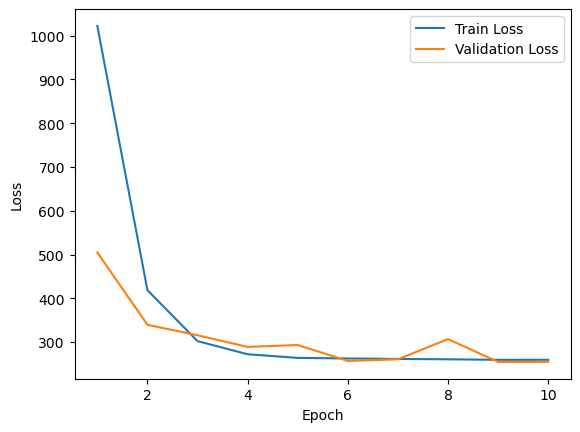

Training model with 100 latent dimensions...
Epoch [1/10], Train Loss: 768.1648, Test Loss: 357.1490
Epoch [2/10], Train Loss: 305.7994, Test Loss: 227.5594
Epoch [3/10], Train Loss: 199.2209, Test Loss: 174.1101
Epoch [4/10], Train Loss: 494.2898, Test Loss: 169.4193
Epoch [5/10], Train Loss: 161.3738, Test Loss: 153.7218
Epoch [6/10], Train Loss: 161.1892, Test Loss: 149.6583
Epoch [7/10], Train Loss: 289.2595, Test Loss: 151.2491
Epoch [8/10], Train Loss: 154.1796, Test Loss: 147.3329
Epoch [9/10], Train Loss: 274.0136, Test Loss: 168.8073
Epoch [10/10], Train Loss: 155.4741, Test Loss: 156.3270


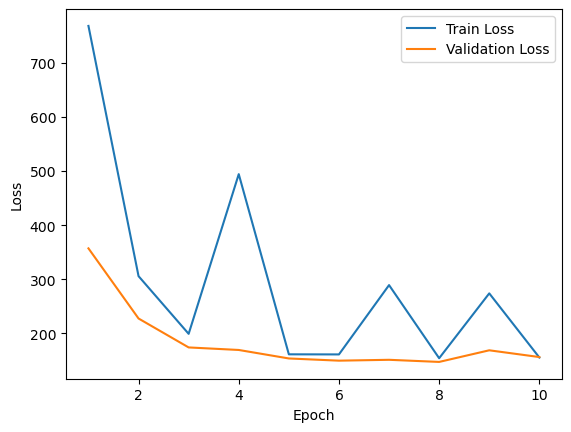

Training model with 500 latent dimensions...
Epoch [1/10], Train Loss: 2104.6724, Test Loss: 176.8661
Epoch [2/10], Train Loss: 176.9741, Test Loss: 156.6243
Epoch [3/10], Train Loss: 137.1151, Test Loss: 121.2919
Epoch [4/10], Train Loss: 4898.9869, Test Loss: 119.2897
Epoch [5/10], Train Loss: 179.8131, Test Loss: 91.6206
Epoch [6/10], Train Loss: 110.1124, Test Loss: 89.1567
Epoch [7/10], Train Loss: 115.4350, Test Loss: 168.3236
Epoch [8/10], Train Loss: 3065.6690, Test Loss: 145.1415
Epoch [9/10], Train Loss: 129.7883, Test Loss: 70.2606
Epoch [10/10], Train Loss: 81.0157, Test Loss: 68.1495


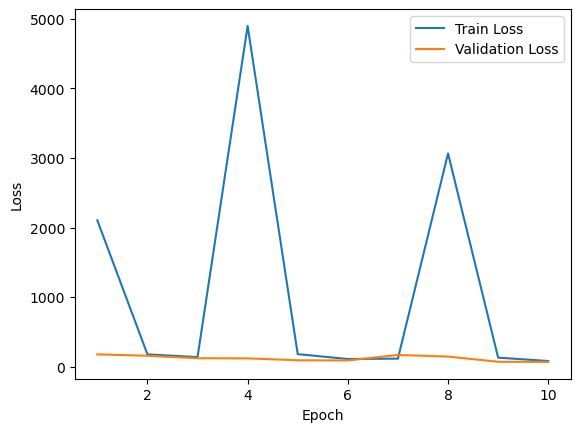

In [29]:
for latent_dim in [2,5,10,25,50,100,500]: # train for [2,5,10,25,50,100,500] latent dims

    print("Training model with", latent_dim,"latent dimensions...")

    input_dim = 4900  # Dimensionality of the input data

    model = Autoencoder(input_dim, latent_dim)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    batch_size = 64
    best_test_loss = float('inf')
    best_model_state = None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0

        # Training
        model.train()
        for batch in train_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch

                # Forward pass
                reconstructions = model(images)
                loss = criterion(reconstructions, images)

                test_loss += loss.item() * images.size(0)

            test_loss /= len(val_loader.dataset)
            test_losses.append(test_loss)

            # Check if current model has the lowest test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = model.state_dict().copy()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Plotting train and test loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Load the best model state (lowest test loss)
    model.load_state_dict(best_model_state)
    torch.save(model, '../models/alpub_autoencoder_dim_'+str(latent_dim)+'.pt')

Test results for latent dim 2 ...


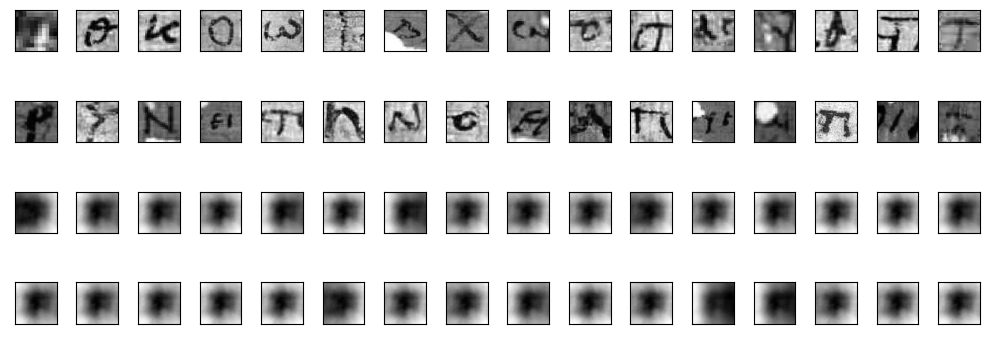

Test results for latent dim 5 ...


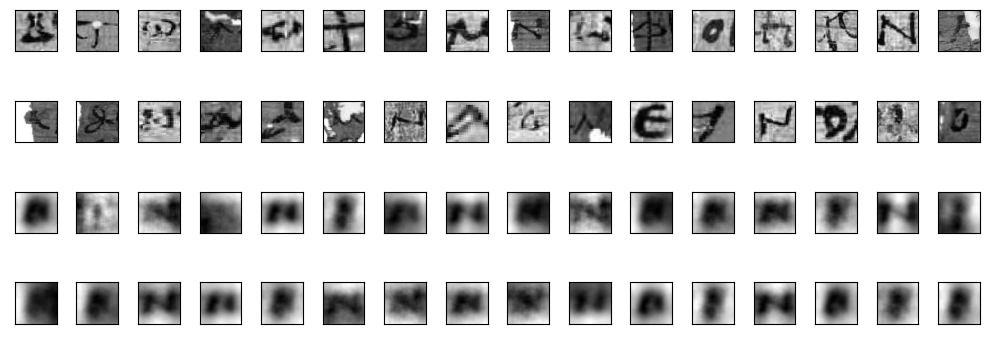

Test results for latent dim 10 ...


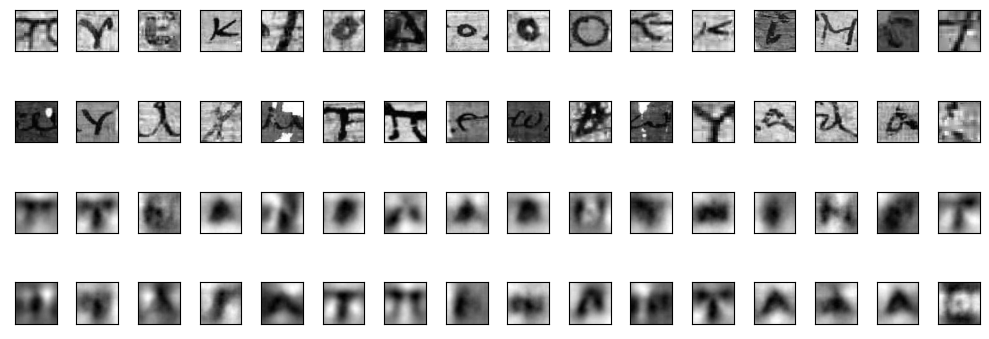

Test results for latent dim 25 ...


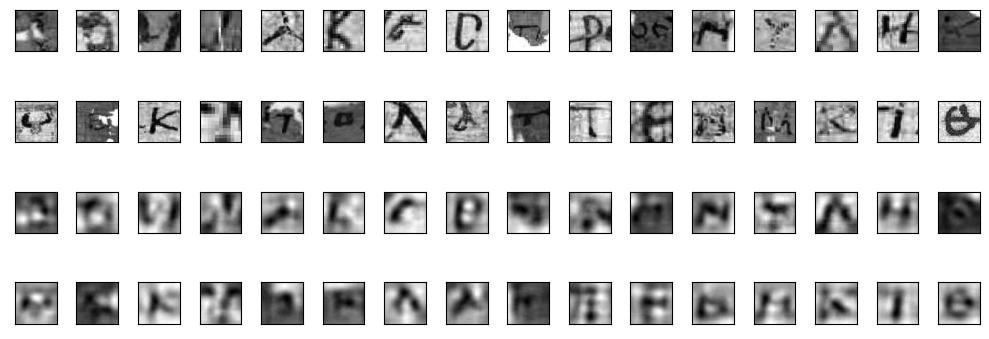

Test results for latent dim 50 ...


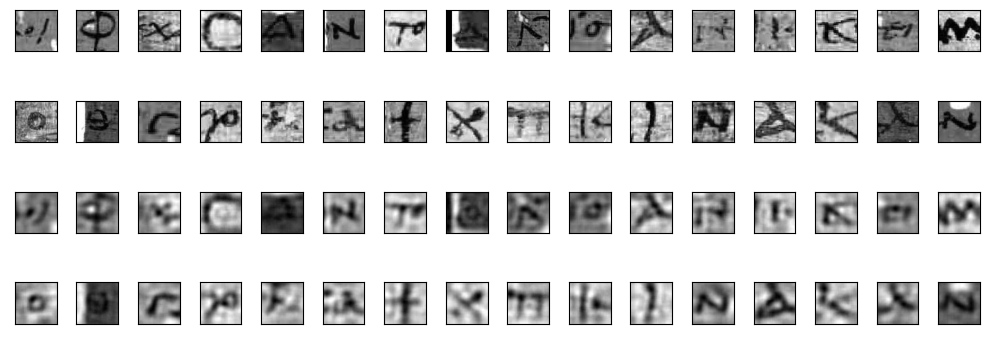

Test results for latent dim 100 ...


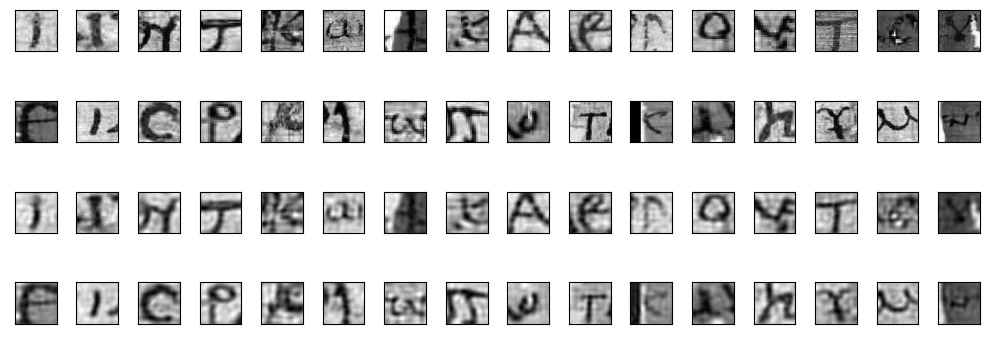

Test results for latent dim 500 ...


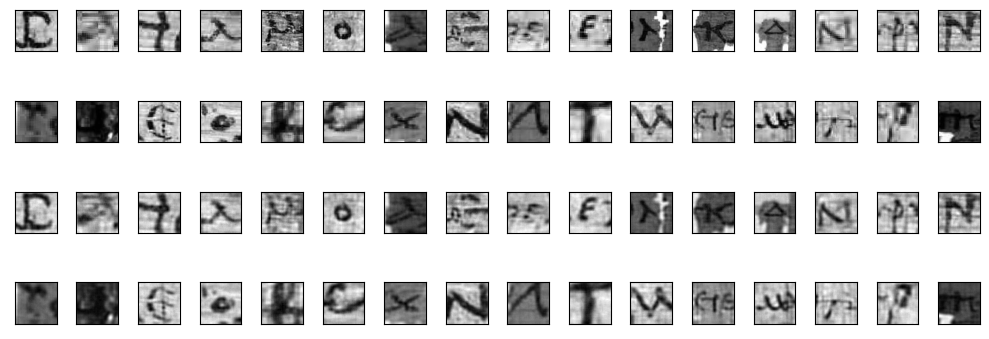

In [39]:
for latent_dim in [2,5,10,25,50,100,500]: # evaluate for [2,5,10,25,50,100,500] latent dims

    print('Test results for latent dim', latent_dim, '...')

    model = torch.load('../models/alpub_autoencoder_dim_'+str(latent_dim)+'.pt')
    # Set the model to evaluation mode
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Get a batch of test data
    test_batch = next(iter(test_loader))
    test_images, _ = test_batch

    # Pass the test data through the model
    with torch.no_grad():
        reconstructions = model(test_images)

    # Plot the original images and their reconstructions
    fig, axes = plt.subplots(nrows=4, ncols=batch_size // 4, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        if i < batch_size // 2:
            # Plot original image
            ax.imshow(test_images[i].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        else:
            # Plot reconstructed image
            ax.imshow(reconstructions[i - batch_size // 2].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])


    plt.tight_layout()
    plt.show()

In [16]:
# Multilayered Autoencoder model
class MultiAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3):
        super(MultiAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_3),
            nn.ReLU(),
            nn.Linear(hidden_dim_3, latent_dim)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim_3),
            nn.ReLU(),
            nn.Linear(hidden_dim_3, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, input_dim),
            #nn.Sigmoid()  # Add a sigmoid activation if the input data is normalized between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Training model with 2 latent dimensions...
Epoch [1/10], Train Loss: 1030.5904, Test Loss: 986.3139
Epoch [2/10], Train Loss: 980.9588, Test Loss: 1019.7341
Epoch [3/10], Train Loss: 999.1808, Test Loss: 973.4783
Epoch [4/10], Train Loss: 970.5647, Test Loss: 983.7365
Epoch [5/10], Train Loss: 970.9714, Test Loss: 955.9310
Epoch [6/10], Train Loss: 972.4343, Test Loss: 964.2419
Epoch [7/10], Train Loss: 980.0834, Test Loss: 952.9410
Epoch [8/10], Train Loss: 964.9679, Test Loss: 948.3695
Epoch [9/10], Train Loss: 956.7108, Test Loss: 956.2263
Epoch [10/10], Train Loss: 964.8323, Test Loss: 980.2940


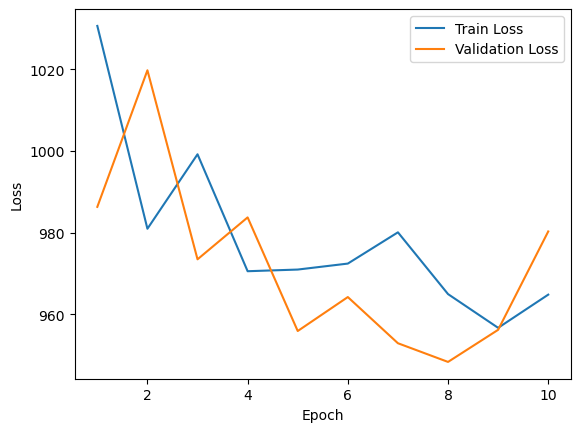

Training model with 5 latent dimensions...
Epoch [1/10], Train Loss: 854.8238, Test Loss: 745.8464
Epoch [2/10], Train Loss: 738.3728, Test Loss: 720.8947
Epoch [3/10], Train Loss: 720.8197, Test Loss: 718.5709
Epoch [4/10], Train Loss: 710.3848, Test Loss: 700.4271
Epoch [5/10], Train Loss: 701.1588, Test Loss: 714.1558
Epoch [6/10], Train Loss: 695.6590, Test Loss: 688.9562
Epoch [7/10], Train Loss: 690.5387, Test Loss: 691.5576
Epoch [8/10], Train Loss: 687.0971, Test Loss: 680.7637
Epoch [9/10], Train Loss: 684.7069, Test Loss: 685.5151
Epoch [10/10], Train Loss: 683.2368, Test Loss: 683.3921


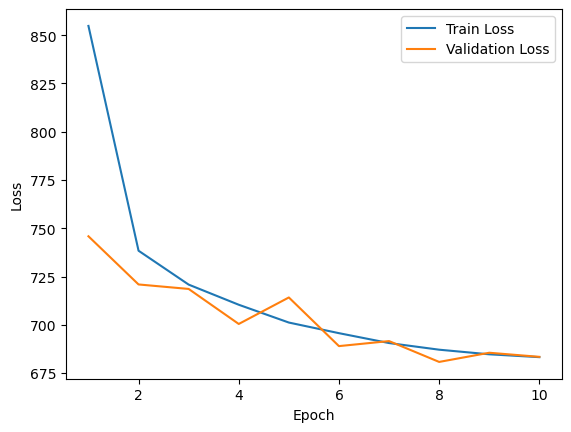

Training model with 10 latent dimensions...
Epoch [1/10], Train Loss: 920.2537, Test Loss: 664.1990
Epoch [2/10], Train Loss: 613.1043, Test Loss: 580.3563
Epoch [3/10], Train Loss: 575.9357, Test Loss: 563.8762
Epoch [4/10], Train Loss: 563.3618, Test Loss: 554.8876
Epoch [5/10], Train Loss: 553.9268, Test Loss: 552.7806
Epoch [6/10], Train Loss: 547.4915, Test Loss: 548.3053
Epoch [7/10], Train Loss: 542.9819, Test Loss: 538.7918
Epoch [8/10], Train Loss: 538.4295, Test Loss: 538.4481
Epoch [9/10], Train Loss: 535.4090, Test Loss: 540.2556
Epoch [10/10], Train Loss: 532.3439, Test Loss: 535.4610


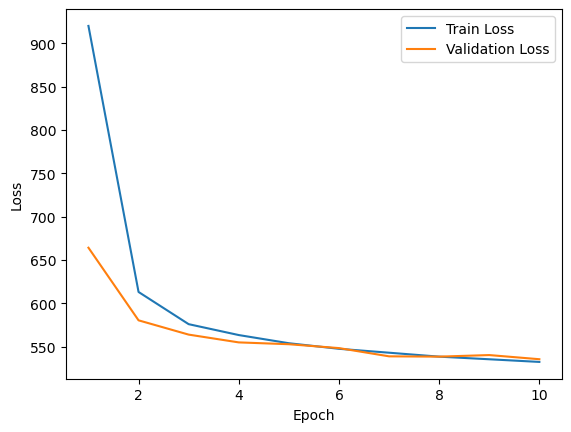

Training model with 25 latent dimensions...
Epoch [1/10], Train Loss: 867.0489, Test Loss: 600.0172
Epoch [2/10], Train Loss: 525.5992, Test Loss: 479.3198
Epoch [3/10], Train Loss: 452.0871, Test Loss: 426.3948
Epoch [4/10], Train Loss: 410.2550, Test Loss: 401.6923
Epoch [5/10], Train Loss: 391.1019, Test Loss: 378.5582
Epoch [6/10], Train Loss: 375.5275, Test Loss: 373.7384
Epoch [7/10], Train Loss: 369.0839, Test Loss: 362.9296
Epoch [8/10], Train Loss: 359.9287, Test Loss: 358.3420
Epoch [9/10], Train Loss: 355.4273, Test Loss: 351.6346
Epoch [10/10], Train Loss: 352.5920, Test Loss: 348.5858


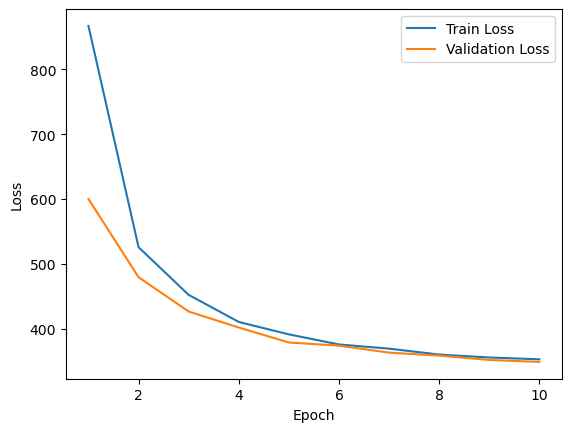

Training model with 50 latent dimensions...
Epoch [1/10], Train Loss: 901.5145, Test Loss: 648.5894
Epoch [2/10], Train Loss: 567.1196, Test Loss: 506.2004
Epoch [3/10], Train Loss: 485.1713, Test Loss: 457.0795
Epoch [4/10], Train Loss: 437.1288, Test Loss: 430.7278
Epoch [5/10], Train Loss: 407.2871, Test Loss: 386.5729
Epoch [6/10], Train Loss: 382.5286, Test Loss: 372.9641
Epoch [7/10], Train Loss: 370.9629, Test Loss: 371.9010
Epoch [8/10], Train Loss: 361.5882, Test Loss: 354.0842
Epoch [9/10], Train Loss: 350.6676, Test Loss: 346.1733
Epoch [10/10], Train Loss: 342.7026, Test Loss: 340.9662


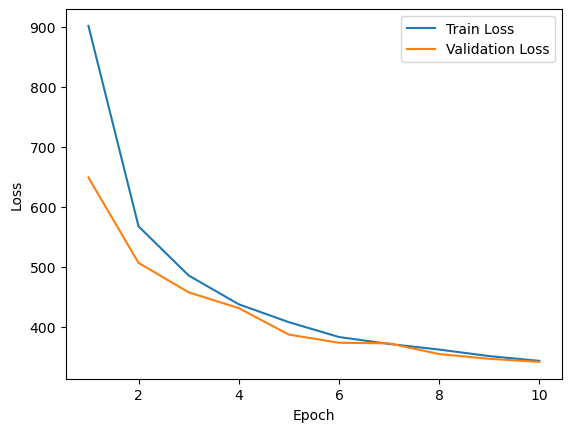

In [18]:
for latent_dim in [2,5,10,25,50]: # train for [2,5,10,25,50] latent dims

    print("Training model with", latent_dim,"latent dimensions...")

    input_dim = 4900  # Dimensionality of the input data
    hidden_dim_1 = 1000
    hidden_dim_2 = 500
    hidden_dim_3 = 100

    model = MultiAutoencoder(input_dim, latent_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    batch_size = 64
    best_test_loss = float('inf')
    best_model_state = None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0

        # Training
        model.train()
        for batch in train_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch

                # Forward pass
                reconstructions = model(images)
                loss = criterion(reconstructions, images)

                test_loss += loss.item() * images.size(0)

            test_loss /= len(val_loader.dataset)
            test_losses.append(test_loss)

            # Check if current model has the lowest test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = model.state_dict().copy()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Plotting train and test loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Load the best model state (lowest test loss)
    model.load_state_dict(best_model_state)
    torch.save(model, '../models/alpub_multi_autoencoder_dim_'+str(latent_dim)+'.pt')

Test results for latent dim 2 ...


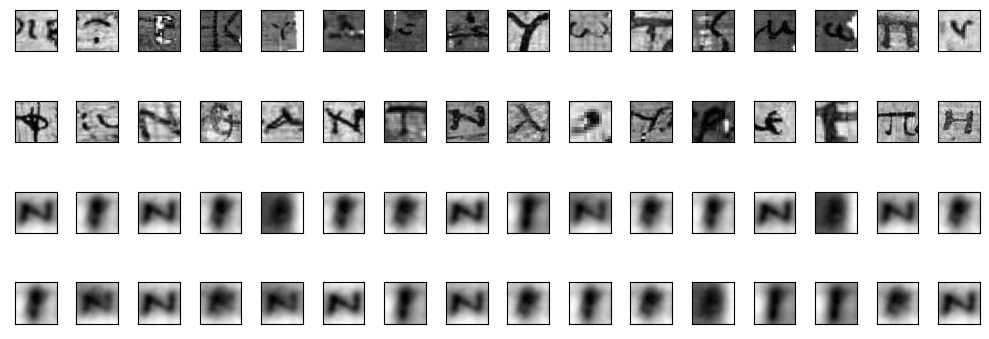

Test results for latent dim 5 ...


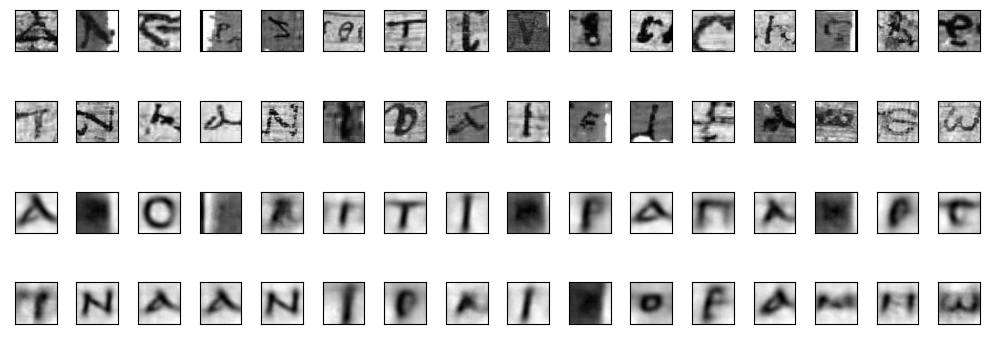

Test results for latent dim 10 ...


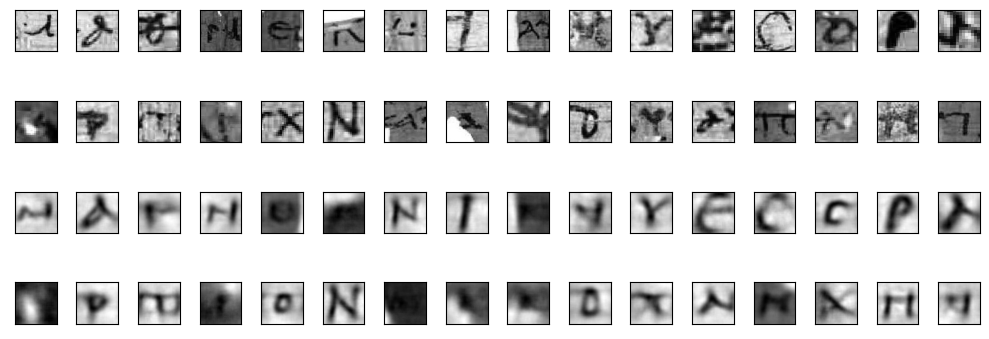

Test results for latent dim 25 ...


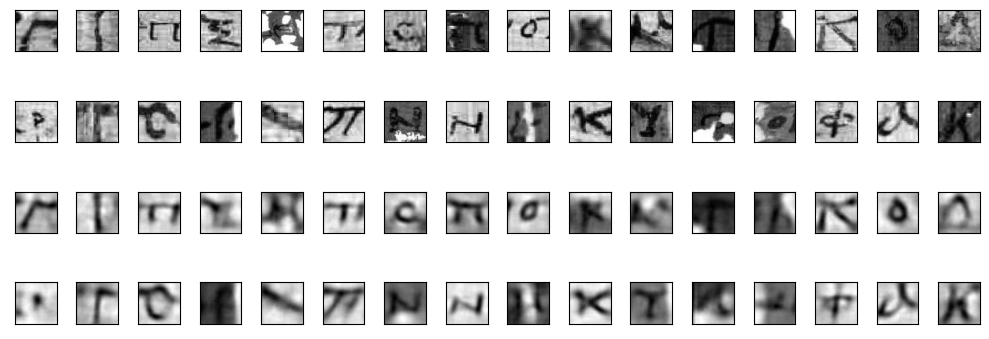

Test results for latent dim 50 ...


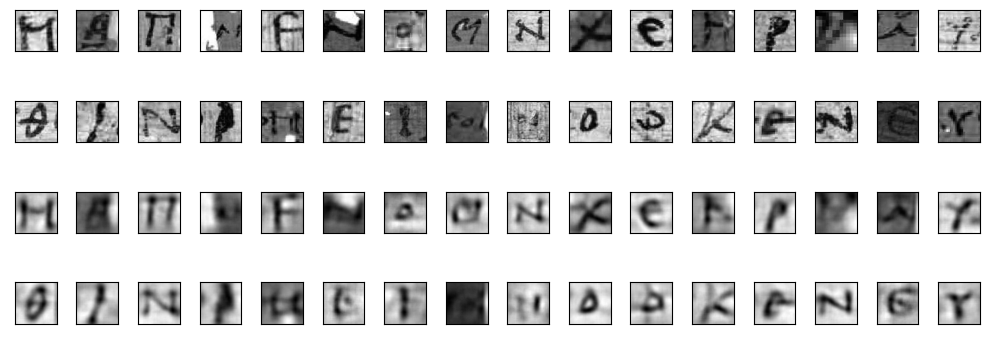

In [19]:
for latent_dim in [2,5,10,25,50]: # evaluate for [2,5,10,25,50] latent dims

    print('Test results for latent dim', latent_dim, '...')

    model = torch.load('../models/alpub_multi_autoencoder_dim_'+str(latent_dim)+'.pt')
    # Set the model to evaluation mode
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Get a batch of test data
    test_batch = next(iter(test_loader))
    test_images, _ = test_batch

    # Pass the test data through the model
    with torch.no_grad():
        reconstructions = model(test_images)

    # Plot the original images and their reconstructions
    fig, axes = plt.subplots(nrows=4, ncols=batch_size // 4, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        if i < batch_size // 2:
            # Plot original image
            ax.imshow(test_images[i].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        else:
            # Plot reconstructed image
            ax.imshow(reconstructions[i - batch_size // 2].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])


    plt.tight_layout()
    plt.show()

In [21]:
# More Multilayered Autoencoder model
class ExtraMultiAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4):
        super(ExtraMultiAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_3),
            nn.ReLU(),
            nn.Linear(hidden_dim_3, hidden_dim_4),
            nn.ReLU(),
            nn.Linear(hidden_dim_4, latent_dim)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim_4),
            nn.ReLU(),
            nn.Linear(hidden_dim_4, hidden_dim_3),
            nn.ReLU(),
            nn.Linear(hidden_dim_3, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, input_dim),
            #nn.Sigmoid()  # Add a sigmoid activation if the input data is normalized between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Training model with 2 latent dimensions...
Epoch [1/20], Train Loss: 1160.6866, Test Loss: 1130.7453
Epoch [2/20], Train Loss: 1138.7726, Test Loss: 1126.6583
Epoch [3/20], Train Loss: 1130.0361, Test Loss: 1125.9940
Epoch [4/20], Train Loss: 1129.0623, Test Loss: 1125.6352
Epoch [5/20], Train Loss: 1127.7335, Test Loss: 1144.3130
Epoch [6/20], Train Loss: 989.4453, Test Loss: 998.2031
Epoch [7/20], Train Loss: 1004.8620, Test Loss: 977.2251
Epoch [8/20], Train Loss: 973.1181, Test Loss: 968.8421
Epoch [9/20], Train Loss: 960.8601, Test Loss: 955.3028
Epoch [10/20], Train Loss: 966.3917, Test Loss: 971.1205
Epoch [11/20], Train Loss: 962.6023, Test Loss: 948.6206
Epoch [12/20], Train Loss: 960.4989, Test Loss: 969.8851
Epoch [13/20], Train Loss: 961.5795, Test Loss: 947.4461
Epoch [14/20], Train Loss: 972.8345, Test Loss: 962.7843
Epoch [15/20], Train Loss: 957.6861, Test Loss: 949.2452
Epoch [16/20], Train Loss: 946.2153, Test Loss: 974.7694
Epoch [17/20], Train Loss: 974.6513, Test L

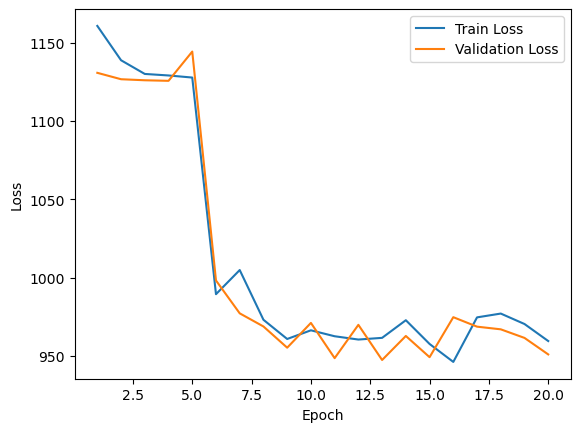

Training model with 3 latent dimensions...
Epoch [1/20], Train Loss: 1151.7957, Test Loss: 1126.2684
Epoch [2/20], Train Loss: 1133.7679, Test Loss: 1125.2009
Epoch [3/20], Train Loss: 1128.9582, Test Loss: 1126.2043
Epoch [4/20], Train Loss: 1129.7059, Test Loss: 1126.1853
Epoch [5/20], Train Loss: 1127.5303, Test Loss: 1125.5662
Epoch [6/20], Train Loss: 1127.3855, Test Loss: 1124.1925
Epoch [7/20], Train Loss: 1126.8908, Test Loss: 1123.7954
Epoch [8/20], Train Loss: 1126.5715, Test Loss: 1124.0222
Epoch [9/20], Train Loss: 1125.4311, Test Loss: 1123.3263
Epoch [10/20], Train Loss: 1125.4484, Test Loss: 1122.6562
Epoch [11/20], Train Loss: 1125.0499, Test Loss: 1123.0988
Epoch [12/20], Train Loss: 1124.9373, Test Loss: 1123.0741
Epoch [13/20], Train Loss: 1124.5167, Test Loss: 1123.7109
Epoch [14/20], Train Loss: 1124.3887, Test Loss: 1122.2123
Epoch [15/20], Train Loss: 1124.3047, Test Loss: 1122.6852
Epoch [16/20], Train Loss: 1124.0230, Test Loss: 1122.4036
Epoch [17/20], Train L

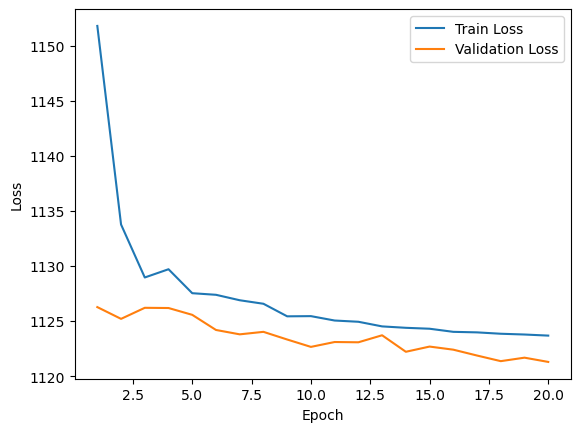

Training model with 5 latent dimensions...
Epoch [1/20], Train Loss: 1074.8400, Test Loss: 979.5309
Epoch [2/20], Train Loss: 908.3157, Test Loss: 874.3768
Epoch [3/20], Train Loss: 871.0248, Test Loss: 862.8112
Epoch [4/20], Train Loss: 868.5135, Test Loss: 860.2713
Epoch [5/20], Train Loss: 863.3754, Test Loss: 850.0515
Epoch [6/20], Train Loss: 848.0460, Test Loss: 848.9296
Epoch [7/20], Train Loss: 839.7076, Test Loss: 837.9822
Epoch [8/20], Train Loss: 836.6181, Test Loss: 862.5366
Epoch [9/20], Train Loss: 833.3657, Test Loss: 842.1791
Epoch [10/20], Train Loss: 843.4907, Test Loss: 836.0323
Epoch [11/20], Train Loss: 832.2304, Test Loss: 853.6303
Epoch [12/20], Train Loss: 842.9412, Test Loss: 835.9027
Epoch [13/20], Train Loss: 837.4669, Test Loss: 825.8414
Epoch [14/20], Train Loss: 831.9613, Test Loss: 843.3959
Epoch [15/20], Train Loss: 830.2981, Test Loss: 827.1622
Epoch [16/20], Train Loss: 841.2189, Test Loss: 839.0262
Epoch [17/20], Train Loss: 846.2864, Test Loss: 836.3

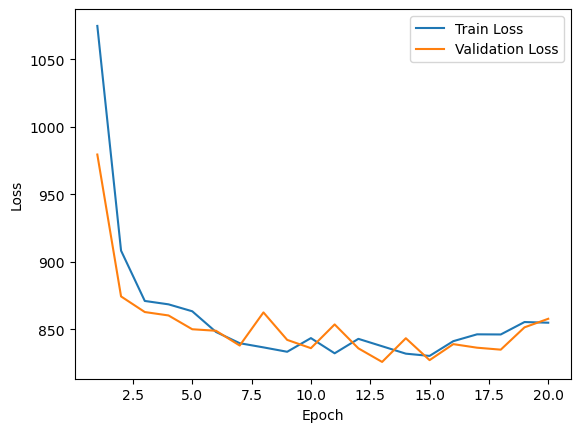

In [22]:
for latent_dim in [2,3,5]: # train for [2,3,5] latent dims

    print("Training model with", latent_dim,"latent dimensions...")

    input_dim = 4900  # Dimensionality of the input data
    hidden_dim_1 = 1000
    hidden_dim_2 = 500
    hidden_dim_3 = 100
    hidden_dim_4 = 10

    model = ExtraMultiAutoencoder(input_dim, latent_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    batch_size = 64
    best_test_loss = float('inf')
    best_model_state = None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0

        # Training
        model.train()
        for batch in train_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch

                # Forward pass
                reconstructions = model(images)
                loss = criterion(reconstructions, images)

                test_loss += loss.item() * images.size(0)

            test_loss /= len(val_loader.dataset)
            test_losses.append(test_loss)

            # Check if current model has the lowest test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = model.state_dict().copy()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Plotting train and test loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Load the best model state (lowest test loss)
    model.load_state_dict(best_model_state)
    torch.save(model, '../models/alpub_extra_multi_autoencoder_dim_'+str(latent_dim)+'.pt')

Test results for latent dim 2 ...


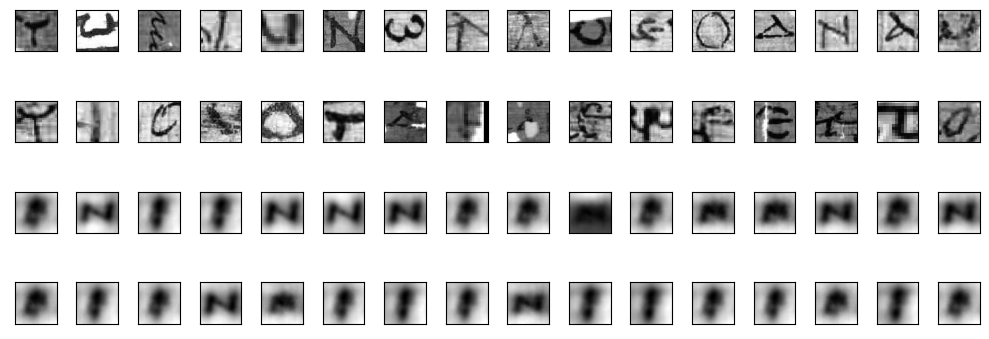

Test results for latent dim 3 ...


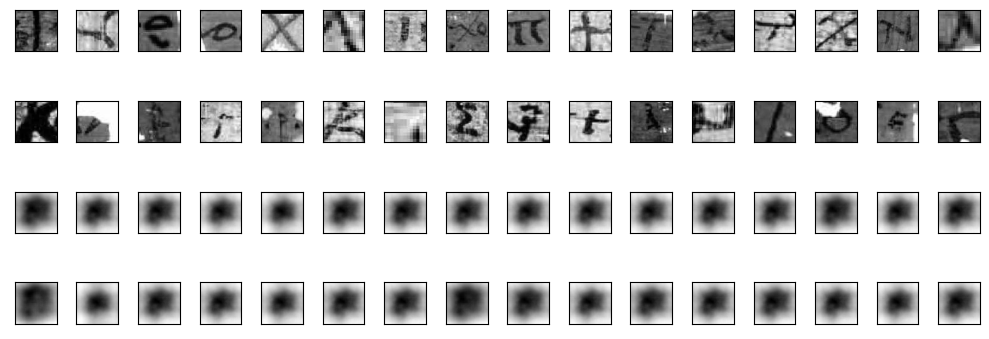

Test results for latent dim 5 ...


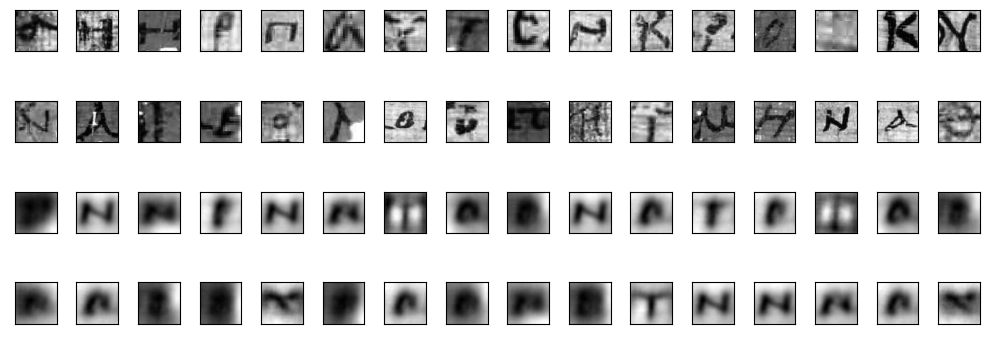

In [23]:
for latent_dim in [2,3,5]: # evaluate for [2,3,5] latent dims

    print('Test results for latent dim', latent_dim, '...')

    model = torch.load('../models/alpub_extra_multi_autoencoder_dim_'+str(latent_dim)+'.pt')
    # Set the model to evaluation mode
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Get a batch of test data
    test_batch = next(iter(test_loader))
    test_images, _ = test_batch

    # Pass the test data through the model
    with torch.no_grad():
        reconstructions = model(test_images)

    # Plot the original images and their reconstructions
    fig, axes = plt.subplots(nrows=4, ncols=batch_size // 4, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        if i < batch_size // 2:
            # Plot original image
            ax.imshow(test_images[i].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        else:
            # Plot reconstructed image
            ax.imshow(reconstructions[i - batch_size // 2].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])


    plt.tight_layout()
    plt.show()